In [1]:
# python imports
import os
import time
import functools

import numpy as np
from scipy import stats
from scipy.stats import uniform, norm, t as tdist, ttest_ind


In [2]:
# setup graphs
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib import rc

plt.rcParams['figure.figsize'] = 8, 3.5
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['figure.dpi'] = 100;

# numpy print format
np.set_printoptions(linewidth=120, precision=4, suppress=False, formatter={'float': '{:5.3e}'.format})

In [3]:
# local imports
import util.tests as tests
import util.dwdb_reader as io
import util.func as f


DpawsTools not found. Fall back to scipy


In [4]:
small_value = 1e-300
tvla_thrd = 4.5 * np.sqrt(2)

tracenum = 1000
step = 50
# Not needed now
# sample_start = 120 # 30  100    # 40
# sample_end =   130 # 50  500    # 180
# rlen = sample_end - sample_start

PROJECT_ROOT_DIR=os.getcwd()
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(IMAGES_PATH): os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load traces and classification

In [5]:
# Read first sample point, split by classification (2 traces, c1 and c2)
print("Reading FP traces")
dsrfp = io.dwdb_reader(r'FP_db_small/log.dwdb', r'FP_db_small')
data_batch_fp, meta_batch_fp = dsrfp.read_batch(10)
print("Done")

print("Reading TP traces")
dsrtp = io.dwdb_reader(r'TP_db_small/log.dwdb', r'TP_db_small')
data_batch_tp, meta_batch_tp = dsrtp.read_batch(10)
print("Done")

pt_range = slice(2,4)
data_batch0, meta_batch0 = data_batch_fp[pt_range], meta_batch_fp[pt_range]
data_batch1, meta_batch1 = data_batch_tp[pt_range], meta_batch_tp[pt_range]

Reading FP traces
Done
Reading TP traces
Done


In [6]:
# Convert traces to numpy
traces_fp = np.asarray(data_batch0)
traces_tp = np.asarray(data_batch1)
traces_fp.shape, traces_tp.shape

((2L, 1000L), (2L, 1000L))

In [7]:
# Extract classifiers, convert to numpy
meta_prep = [m['other'].split() for m in meta_batch0]
classifiers = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('s=')]
classifiers = [str(int(c)-1) for c in classifiers]
classifiers_fp = np.asarray(classifiers)
meta_prep = [m['other'].split() for m in meta_batch1]
classifiers = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('s=')]
classifiers_tp = np.asarray(classifiers)

classifiers_fp, classifiers_tp

(array(['0', '1'], dtype='|S1'), array(['0', '1'], dtype='|S1'))

In [8]:
# Postprocessing 1 (make dwdb table)
tr_num = 2*traces_fp.shape[1]
# 1. 2 traces should be transposed and merged in 1 sample point
traces_fp = traces_fp.reshape(tr_num, 1)
traces_tp = traces_tp.reshape(tr_num, 1)
# 2. classifiers should be stretched as the 1st half of the sample point is R1 and 2nd one is R2
classifiers_fp = np.repeat(classifiers_fp, tr_num/2).reshape(tr_num, 1)
classifiers_tp = np.repeat(classifiers_tp, tr_num/2).reshape(tr_num, 1)
# traces_np[:4], classifiers_np[:4]
print(traces_fp.shape, classifiers_fp.shape, traces_tp.shape, classifiers_tp.shape)
print(np.all(classifiers_fp == classifiers_tp))

((2000L, 1L), (2000L, 1L), (2000L, 1L), (2000L, 1L))
True


In [9]:
# Postprocessing 2 (make multipoint, really 2 points (TP, FP) so far)
# Given that first 1000 traces are classified 0s and second 1000 are 1s, 
# merge traces to one dataset, where even sample point are TP and odd ones are FP
# Classifires are the same
traces_np = np.empty((traces_fp.shape[0], 2))
traces_np[:, 0] = traces_tp[:, 0]
traces_np[:, 1] = traces_fp[:, 0]
classifiers_np = classifiers_fp
traces_np.shape

(2000L, 2L)

In [10]:
# Sanity check, print border
print(traces_np[997:1003])
print(classifiers_np[997:1003])

[[5.000e+00 4.218e+00]
 [5.000e+00 4.624e+00]
 [5.000e+00 5.673e+00]
 [5.650e+00 7.707e+00]
 [5.545e+00 3.710e+00]
 [3.456e+00 1.011e+01]]
[['0']
 ['0']
 ['0']
 ['1']
 ['1']
 ['1']]


In [11]:
# Postprocessing 3 (randomize traces)
# classifiers go as [000 all zeros, 111 all ones], it breaks evolution
# data should be shuffled, taking classifiers_fp as a common one
tracenum = tr_num # update tracenum to the actual value
perm_ind = np.random.permutation(np.arange(tracenum))
traces_np, classifiers_np = traces_np[perm_ind], classifiers_np[perm_ind]
traces_np.shape, classifiers_np.shape

((2000L, 2L), (2000L, 1L))

In [12]:
# Make sure traces are shuffled right, print the border
print(traces_np[997:1003])
print(classifiers_np[997:1003])

[[5.818e+00 5.806e+00]
 [4.601e+00 1.887e+00]
 [5.000e+00 5.504e+00]
 [5.000e+00 5.608e+00]
 [5.000e+00 6.296e+00]
 [5.000e+00 2.969e+00]]
[['1']
 ['1']
 ['0']
 ['0']
 ['0']
 ['0']]


## Sanity check. Make sure it leaks

In [13]:
np.mean(traces_np, axis=0), np.var(traces_np, axis=0)

(array([4.859e+00, 4.968e+00]), array([1.920e+00, 3.909e+00]))

In [14]:
tt = tests.fvr_ttest(traces_np, classifiers_np)
tracenum, tt

(2000L, array([-4.579e+00, 5.157e+00]))

<IPython.core.display.Javascript object>


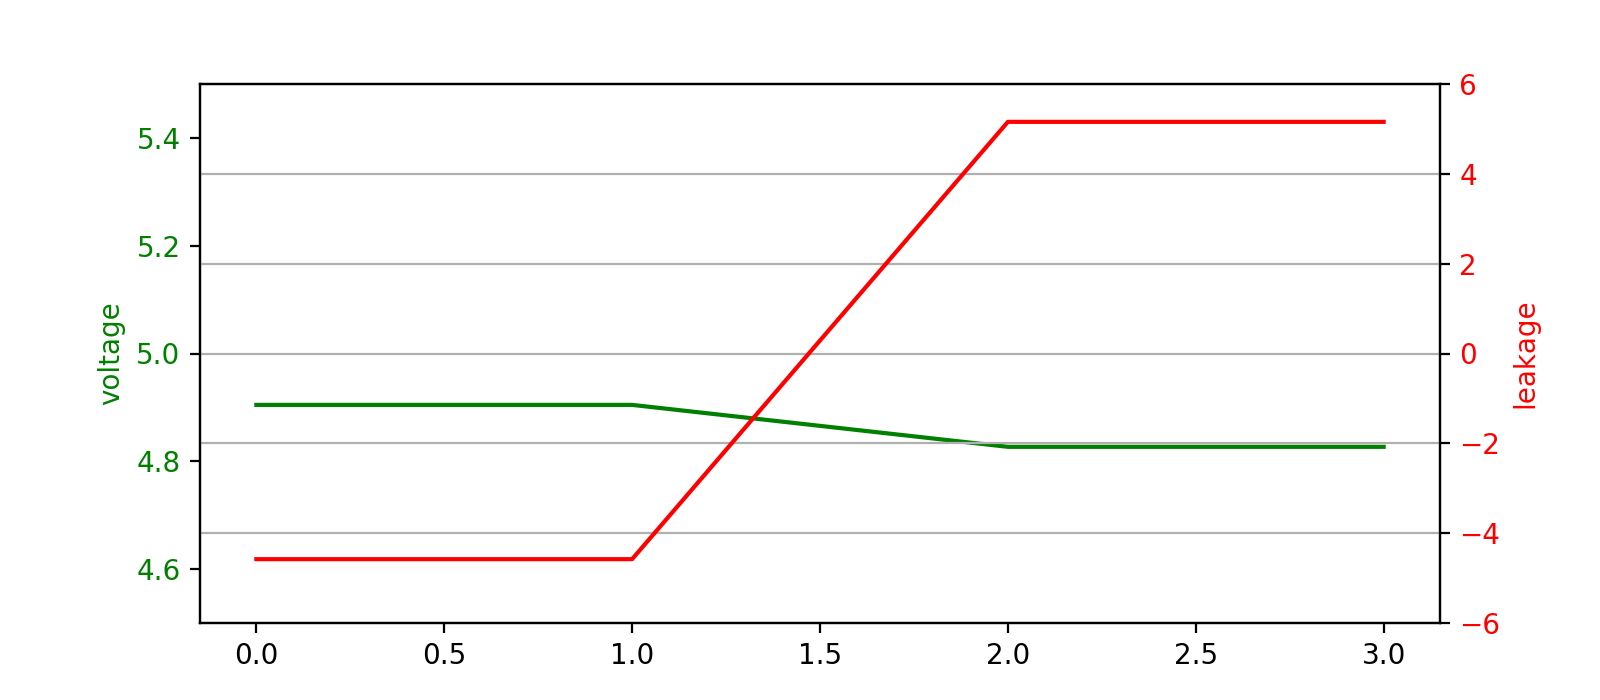

In [15]:
rangex = np.arange(2)
data_trace1 = np.mean(traces_np[:100], axis=0)
data_trace = np.repeat(data_trace1, len(rangex))
tt_trace = np.repeat(tt, len(rangex))

fig, ax1 = plt.subplots()
ax1.set_ylabel('voltage', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.set_ylabel('leakage', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_ylim(4.5, 5.5)
ax1.plot(data_trace, color='g')   # signal
ax2.set_ylim(-6, 6)
ax2.plot(tt_trace, color='r')     # leak
plt.grid()
plt.show()

## Evolution

In [16]:
evo_step = step
evo_tstat = np.empty(((tracenum+1)/evo_step, traces_np.shape[1]))
evo_xrange = np.arange(evo_step, tracenum+1, evo_step)
for i, ex in enumerate(evo_xrange):
    start = time.time()
    tt = tests.fvr_ttest(traces_np[:ex], classifiers_np[:ex])
    evo_tstat[i,:] = tt
    if i % evo_step == 0:
        print("Trace count: {}, tt: {}, done in {}".format(ex, tt, time.time() - start))
evo_tstat = np.abs(evo_tstat) # comment out for intermediates

# Max leakage info
tr_num, max_leak_pt = np.unravel_index(np.argmax(evo_tstat), evo_tstat.shape)
max_leak_val, max_leak_at = evo_tstat[tr_num, max_leak_pt], tr_num*evo_step
max_leak_pv = tdist.sf(max_leak_val, max_leak_at)
print("Max leak at point: {}, value: {:5.3e} (pv: {:5.3e}), trace: {}".format(
    max_leak_pt, max_leak_val, max_leak_pv, max_leak_at))

Trace count: 50, tt: [-4.102e-02 1.744e-02], done in 0.00100016593933
Max leak at point: 1, value: 5.320e+00 (pv: 5.819e-08), trace: 1850


<IPython.core.display.Javascript object>


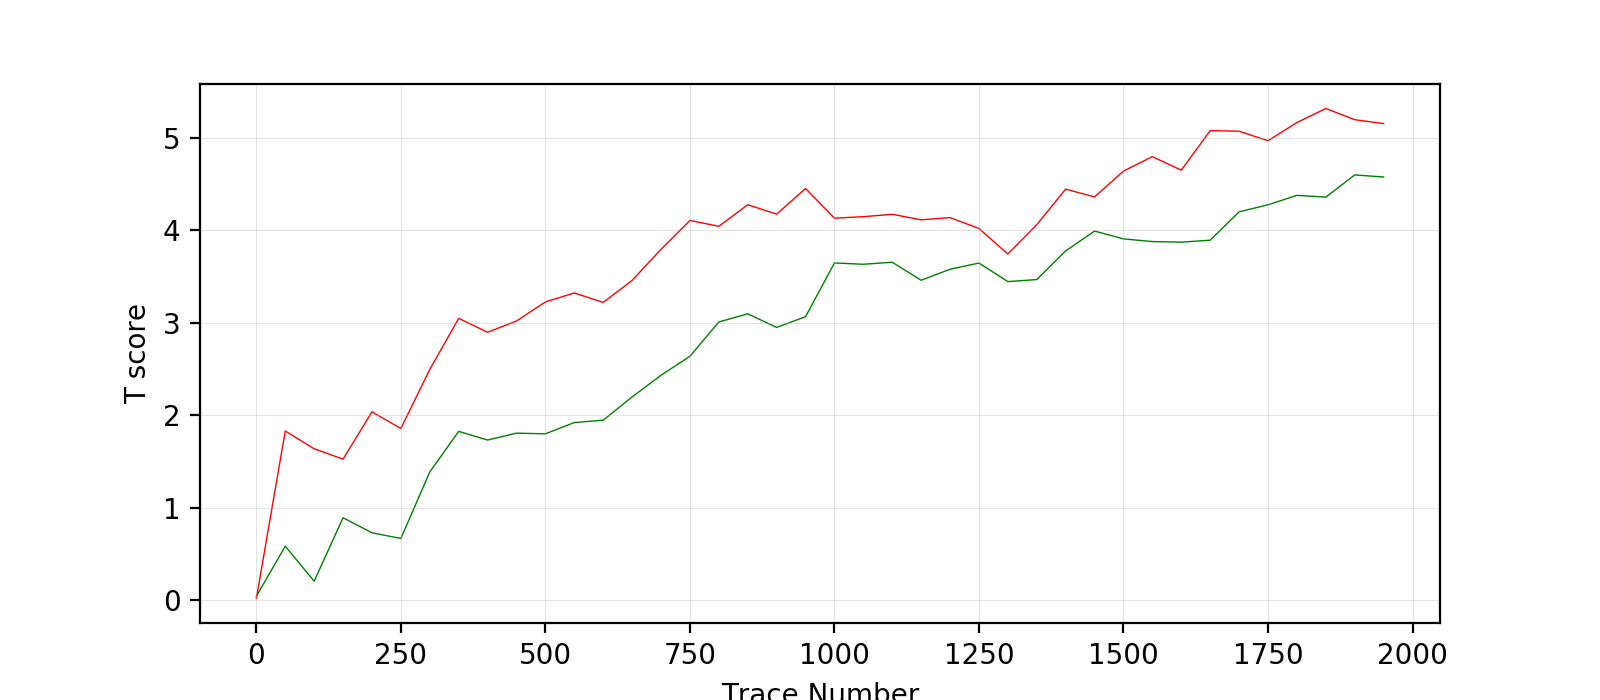

In [17]:
step_num, pt_num = np.shape(evo_tstat)

fig = plt.figure()
plt.ylabel('T score')
plt.xlabel('Trace Number')
# plt.axhline(y=tvla_thrd, color='r', linestyle=':')

x_axis = np.arange(step_num) * evo_step

# leak history for each TP point (green)
for j in range(0, pt_num, 2):
    plk = evo_tstat[:, j]
    plt.plot(x_axis, plk, linewidth=0.5, linestyle='-', color = 'g', zorder = j)

# leak history for each FP point (red)
for j in range(1, pt_num, 2):
    plk = evo_tstat[:, j]
    plt.plot(x_axis, plk, linewidth=0.5, linestyle='-', color = 'r', zorder = j)

plt.grid(alpha=.5, linewidth=.25)
plt.show()

## Bootstrapping

In [18]:
pt_num = traces_np.shape[1]
boots_list = [21, 41, 61, 81, 101]  # iterations in a boot
boot_step = step
boot_till = tracenum
ld_stat = stats.uniform
ld_cdf = ld_stat().cdf

tt_boots_per_step = []  # cannot be numpy array due to different lengths per boot
tp_boots_per_step = []  # cannot be numpy array due to different lengths per boot
ksp_per_step = []
step_ranges = np.arange(boot_step, boot_till+1, boot_step)
for steprange in step_ranges:
    # Run all boots for a step
    tt_full_per_boot, tp_full_per_boot, ksp_per_boot = [], [], []
    for j, boots in enumerate(boots_list):
        start = time.time()
        tt_full = np.empty((boots, pt_num), dtype=np.float64)
        tp_full = np.empty_like(tt_full)
        ks_full = np.empty_like(tp_full[0])
        boot_idxs = np.random.randint(steprange-boot_step, steprange, size=(boots, boot_step))
        for i, bi in enumerate(boot_idxs):
            tt_full[i] = tests.fvr_ttest(traces_np[bi], classifiers_np[bi]) # calc tt and keep it
            tp_full[i] = tdist.sf(tt_full[i], steprange)                    # convert tt to pv and keep it
        # Run ks-test for p-value set in each sample point
        for i, pt_boots in enumerate(tp_full.T):
            ks_full[i] = f.kstest(pt_boots, ld_cdf)[1]                      # keep pv only
        tt_full_per_boot.append(np.asarray(tt_full))
        tp_full_per_boot.append(np.asarray(tp_full))
        ksp_per_boot.append(ks_full)
    tt_boots_per_step.append(np.asarray(tt_full_per_boot))
    tp_boots_per_step.append(np.asarray(tp_full_per_boot))
    ksp_per_step.append(ksp_per_boot)
ksp_per_step = np.asarray(ksp_per_step)
ksp_per_step.shape

(40L, 5L, 2L)

# Bootstrapping vizualization

In [19]:
# Prepare data
ksp_per_step[np.where(np.isnan(ksp_per_step))]     = small_value
ksp_per_step[np.where(ksp_per_step < small_value)] = small_value

x_axis = step_ranges
step_num, boot_num, pt_num = np.shape(ksp_per_step)

cpalette = ['g', 'r']

boot_idx = 2


<IPython.core.display.Javascript object>


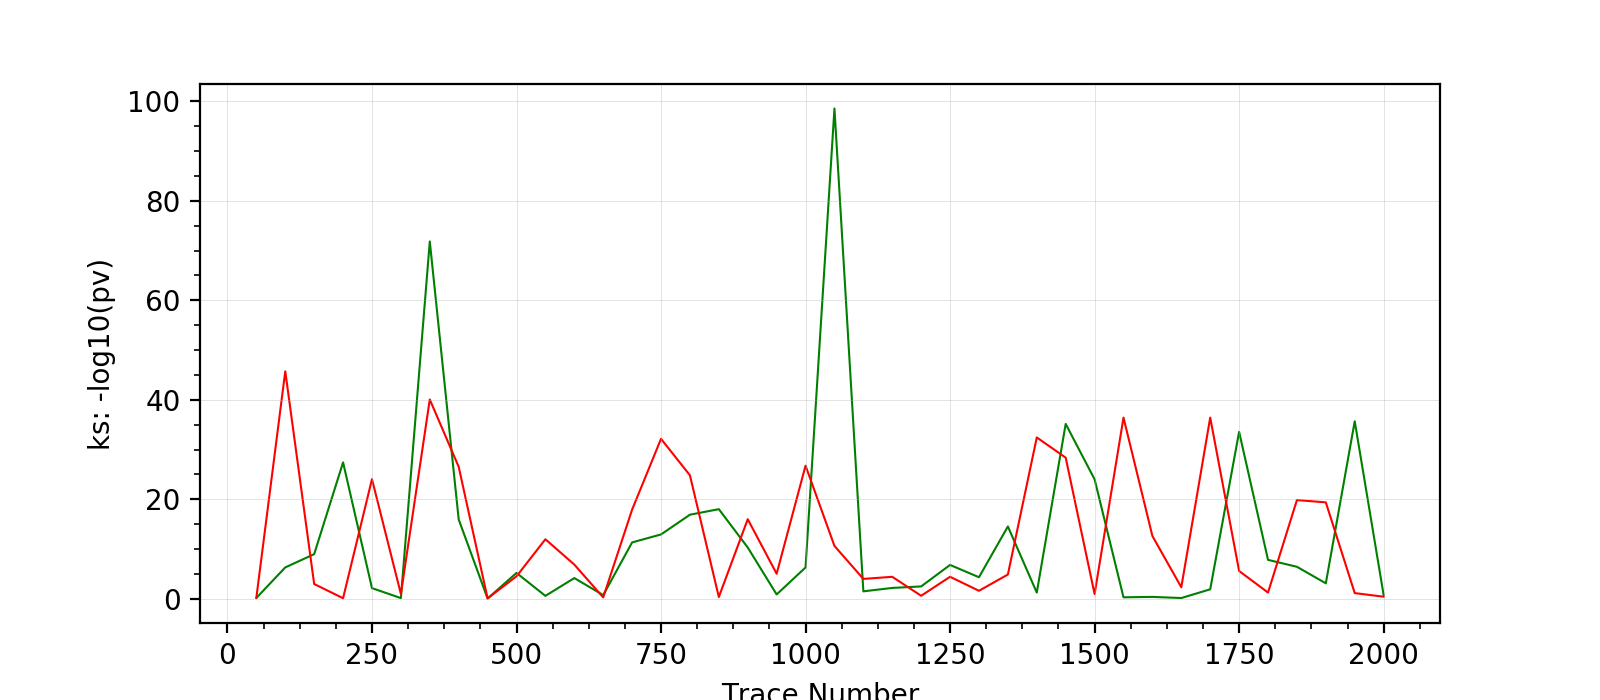

In [20]:
# Unsorted ks results
fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('ks: -log10(pv)')

# Boot evolution for TP
plot_evo = ksp_per_step[:, boot_idx].T
for j in range(0, pt_num, 2):
    kspl = -np.log10(plot_evo[j])
    plt.plot(x_axis, kspl, linewidth=0.75, color = 'g', zorder = j)

# Boot evolution for FP
plot_evo = ksp_per_step[:, boot_idx].T
for j in range(1, pt_num, 2):
    kspl = -np.log10(plot_evo[j])
    plt.plot(x_axis, kspl, linewidth=0.75, color = 'r', zorder = j)

plt.minorticks_on()
plt.grid(alpha=.5, linewidth=.25)
plt.show()
# plot_evo.shape, x_axis.shape

<IPython.core.display.Javascript object>


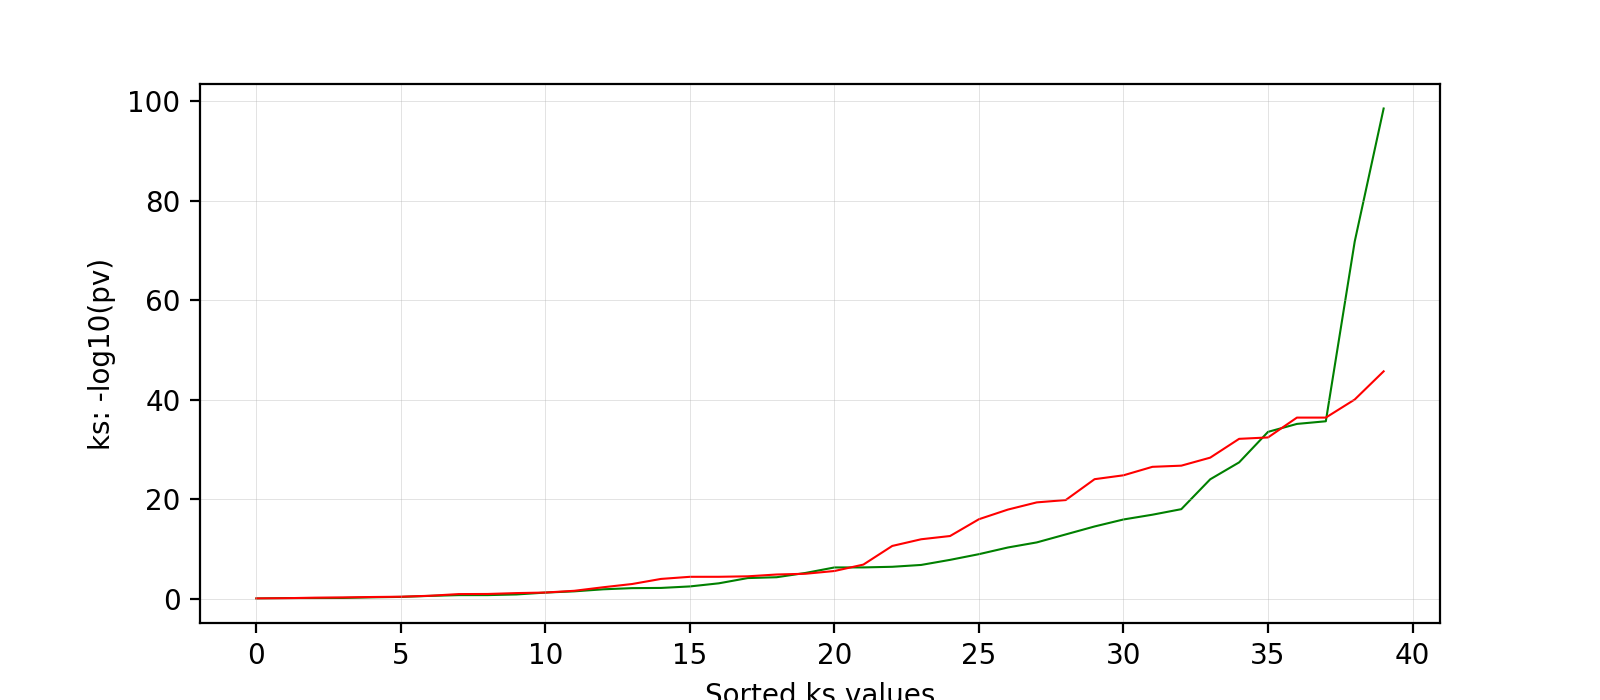

In [21]:
# Sorted ks results
fig = plt.figure()
plt.xlabel('Sorted ks values')
plt.ylabel('ks: -log10(pv)')

# Boot evolution for TP
plot_evo = ksp_per_step[:, boot_idx].T
for j in range(0, pt_num, 2):
    kspl = -np.log10(plot_evo[j])
    kspl = np.sort(kspl)
    plt.plot(kspl, linewidth=0.75, color = 'g', zorder = j)

# Boot evolution for FP
plot_evo = ksp_per_step[:, boot_idx].T
for j in range(1, pt_num, 2):
    kspl = -np.log10(plot_evo[j])
    kspl = np.sort(kspl)
    plt.plot(kspl, linewidth=0.75, color = 'r', zorder = j)

plt.grid(alpha=.5, linewidth=.25)
plt.show()
# plot_evo.shape, x_axis.shape

## Outcome

Seems like growing too fast or the source data should be generated in another manner, or I don't understand something

# Below are cells to debug code snippets

## Debugging ks-test 

In [ ]:
# Find out whether it follows the uniform distribution
ksp_per_step2 = np.zeros_like(tp_full_per_step[:,1])

for s, bps in enumerate(tp_full_per_step):          # step
    bpsr = bps.T                                    # -> (pt, boot)
    start = time.time()
    print('{}: Step {} ...'.format(bpsr.shape, s))
    for i, ptbt in enumerate(bpsr):
        d, kpv = f.kstest(ptbt, ld_cdf)
        ksp_per_step2[s, i] = kpv
    print("Done in {}".format(time.time() - start))


## Debugging distributions for kstest

In [ ]:
tp_boots_per_step[0]

In [ ]:
si = 2

# bpvs = t_full_per_step[si].T  # t
bpvs = tp_boots_per_step[si].T   # t-pv

kpvs = []
leak_dist = stats.uniform
# leak_dist = stats.norm
for j in range(0, len(bpvs)):
    bp = bpvs[j]
    d, pv = f.kstest(bp, leak_dist().cdf)
    l, s = leak_dist.fit(bp)      # loc and scale of the dist at the point
    leaking = pv < 0.05           # 3 sigma assurance the point is leaking (non uniform)
    kpvs.append([d, pv, l, s, leaking])
d, pv = f.kstest(bpvs[mpi], leak_dist().cdf)
l, s = leak_dist.fit(bpvs[mpi])  # loc and scale of the dist at the max leak point
leaking = pv < 0.05
kpvs.append([d, pv, l, s, leaking])

# print("d, pv, l, s, leaking")
# print(np.array(kpvs))
    
# norm_cdf = norm(loc=0, scale=1).cdf
# dt, pv  = stats.kstest(bpvs, norm_cdf)

fig = plt.figure()
plt.xlabel('Boot Number')
for j in range(0, len(bpvs), 20):
    plt.plot(bpvs[j], color = 'grey', linewidth=0.5, zorder = j)

# mpi = 0
# plt.plot(bpvs[mpi], color = 'r', linewidth=2, zorder=255)
plt.show()

## Debugging at some boot